In [1]:
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import paramiko
import io
import shlex
import os
from os.path import join

In [2]:
def setup_ec2():
    print("Connecting to EC2")
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect('3.69.255.112', username='ec2-user', key_filename='airflow-test-key.pem')
    print("Connection successful")
    return ssh

In [13]:
def ec2_plotting(df, folder):
    # create a new directory for the output charts
    output_dir = "data/price_comparison_charts"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    new_folder = join(output_dir,folder)
    os.makedirs(new_folder,exist_ok=True)
    title = df.title.value_counts().idxmax().replace('/','-')

    # get the desired timestamps
    timestamps = df.timestamp.unique()[:4] # change this to select the desired timestamps

    # subset the dataframe to only include the rows corresponding to the desired timestamps
    subset_df = df[df['timestamp'].isin(timestamps)]

    # create a box plot and line plot for the prices, grouped by source
    ax = sns.lineplot(y="price", data=subset_df, x='timestamp', hue='source')
    ax.set(title=title)

    # set the x-axis labels to show the desired timestamps
    plt.xticks(rotation=45)
    ax.set_xticks(timestamps)

    # add text to the box plot to show the number of products from each source
    plt.legend(loc="best")
    file_path = join(new_folder,title)+'.jpg'
    plt.savefig(file_path,format='jpg',dpi=1200)
    plt.close()

In [14]:
def get_data_ec2(ssh, remote_path):
    print("Reading CSV files from " + remote_path)
    escaped_path = shlex.quote(remote_path)
    stdin, stdout, stderr = ssh.exec_command('ls ' + escaped_path + '/*.csv')
    file_list = [filename.strip() for filename in stdout.readlines()]
    # Loop over list of file names and read each CSV file into a pandas DataFrame
    df_list = []
    for filename in file_list:
        transport = ssh.get_transport()
        channel = transport.open_channel('session')
        channel.exec_command('cat ' + filename)
        file_obj = io.StringIO()
        for line in channel.makefile('r'):
            file_obj.write(line)
        file_obj.seek(0)
        df = pd.read_csv(file_obj)
        df_list.append(df)
        channel.close()
    # Concatenate all DataFrames into a single DataFrame
    #df = pd.concat(df_list, ignore_index=True)
    return df_list

In [15]:
def get_folders_ec2(ssh,remote_path):
    print("Reading product folders from " + remote_path)
    escaped_path = shlex.quote(remote_path)
    stdin, stdout, stderr = ssh.exec_command('ls ' + escaped_path)
    file_list = [filename.strip() for filename in stdout.readlines()]
    return file_list

Connecting to EC2
Connection successful
Reading product folders from /home/ec2-user/ecomm/ecomm_comp/ecomm_comp/products
Reading CSV files from /home/ec2-user/ecomm/ecomm_comp/ecomm_comp/products/garmin_smartwatch_2023_03_12_17_13_22_clustered
Plotting the price data CSV's


ConversionError: Failed to convert value(s) to axis units: ['2023-03-13', '2023-03-14', '2023-03-14', '2023-03-14']

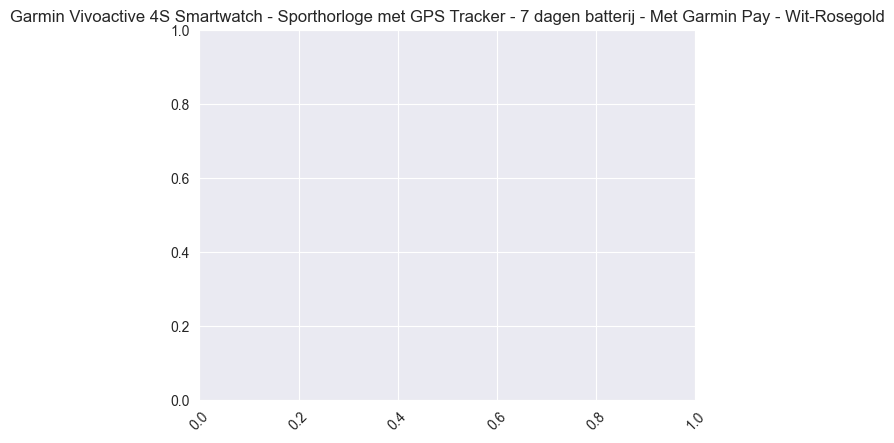

In [16]:
ssh = setup_ec2()
product_path = '/home/ec2-user/ecomm/ecomm_comp/ecomm_comp/products'
folders = get_folders_ec2(ssh,product_path)
for folder in folders:
    remote_path = product_path + '/' + folder
    dfs = get_data_ec2(ssh, remote_path)

    print("Plotting the price data CSV's")
    for df in dfs:
        ec2_plotting(df, folder)
ssh.close()

In [ ]:
dfs[0].columns

In [7]:
dfs[0].shape

(25070, 5)

In [8]:
dfs[0].head()

,price,source,timestamp,link,title
0,215.0,Bol,2023-03-13 16:34:11.001841,https://bol.com/nl/nl/p/garmin-vivoactive-4s-s...,Garmin Vivoactive 4S Smartwatch - Sporthorloge...
1,198.0,Amazon,2023-03-13 16:34:11.001841,https://www.amazon.nl/V%C3%ADvoactive-Training...,Garmin vívoactive 4 — waterdichte GPS-smartwat...
2,199.0,Bol,2023-03-14 19:00:14.476672,https://bol.com/nl/nl/p/garmin-vivoactive-4s-s...,Garmin Vivoactive 4S Smartwatch - Sporthorloge...
3,198.0,Amazon,2023-03-14 19:00:14.476672,https://www.amazon.nl/V%C3%ADvoactive-Training...,Garmin vívoactive 4 — waterdichte GPS-smartwat...
4,199.0,Bol,2023-03-14 20:00:13.901101,https://bol.com/nl/nl/p/garmin-vivoactive-4s-s...,Garmin Vivoactive 4S Smartwatch - Sporthorloge...


In [9]:
original_df = dfs[0]

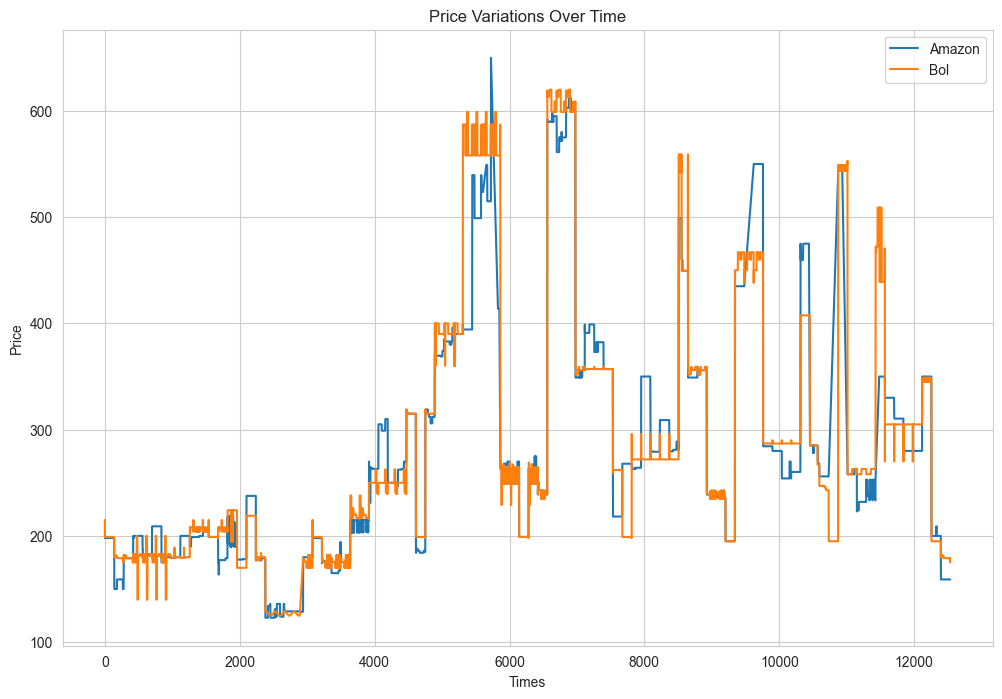

In [11]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))

amazon_data = original_df[original_df['source'] == 'Amazon']
bol_data = original_df[original_df['source'] == 'Bol']

amazon_list = amazon_data["price"].to_list()
bol_list = bol_data["price"].to_list()

# Create a line plot
sns.lineplot(amazon_list, label='Amazon')
sns.lineplot(bol_list, label='Bol')

# Add plot labels and titles
plt.xlabel('Times')
plt.ylabel('Price')
plt.title('Price Variations Over Time')

# Show the plot
plt.show()